In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import sklearn
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [153]:
def get_stock(start, end, stock, restricted_days):
    '''
    Return the data as Numpy arrays and incrementing indexes for each value for the time series.

    Parameters:
    -- start: start date "Year-Month-Day"
    -- end: end date "Year-Month-Day"
    -- stock: The label of the stock to download from yahoo stocks
    -- restriced_days: int, the number of last days to be removed from the dataframe 

    Returns:
    -- df: 1d Numpy array containing all the closing prices from the start to end data except for the last 100 days
    -- restricted_df: Contains the last <restriced_days> days of the data
    -- index: incrementing indexes for the closing prices
    '''
    
    yfd = yf.download(stock, start=start, end=end)
    df = pd.DataFrame({'Close': yfd['Close']})
    df = df.dropna().reset_index(drop=True)

    restricted_df = np.array(df[len(df) - 100:]) # last 100 days prices
    df = np.array(df[:len(df) - 100])
    index = np.linspace(1, df.shape[0], df.shape[0])

    return df, restricted_df, index 

def bin_data(df, bin_size):
    '''
    Returns the data split into bins of size <bin_size>. The bins are used to predict the day on index <bin_size> + 1.
    
    Parameters:
    -- df: dataset containing the closing prices for the stock
    -- bin_size: size of bins for the data

    Returns:
    -- bins: Numpy array size (len(df) - bin_size, bin_size), bins created based on a sliding window incrementing by 1
    '''
    
    bins = np.array([df[i:i + bin_size].T.reshape(-1) for i in range(0, len(df) - bin_size - 1, 1)])
    return bins

In [154]:
# Define the stock and date range
start = '1980-01-01'
end = '2024-10-20'
stock = '^GSPC'
restrict = 100

df, restricted_df, index = get_stock(start, end, stock, restrict)

[*********************100%***********************]  1 of 1 completed


# Visualize The Data

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5267.83984375]
 [5304.72021484]
 [5306.04003906]] (11195, 1)
(11195,) (11195,)


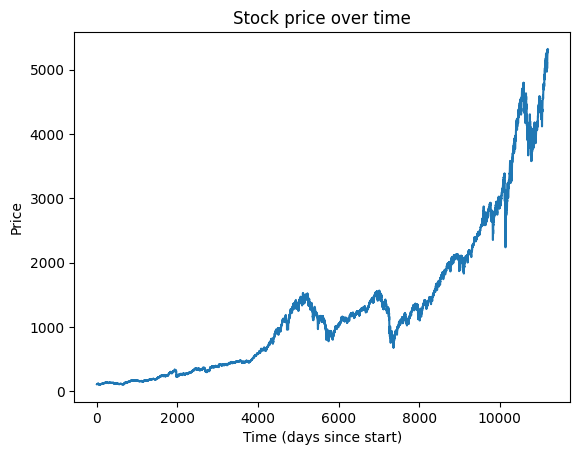

In [155]:
print(df, df.shape)
print(index.shape, df.T[0].shape)

plt.plot(index, df.T[0])
plt.title("Stock price over time")
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.show()


# Split the data into bins

In [160]:
bin_size = 365 # We require the past year of data
bins = bin_data(df, bin_size)

print(bins.shape)
print(bins[0][:5], bins[0].shape)
print(bins[1][:5], bins[1].shape)
print()
print(bins[-1][-10:])

(10829, 365)
[105.76000214 105.22000122 106.51999664 106.80999756 108.94999695] (365,)
[105.22000122 106.51999664 106.80999756 108.94999695 109.05000305] (365,)

[5222.68017578 5221.41992188 5246.68017578 5308.14990234 5297.10009766
 5303.27001953 5308.12988281 5321.41015625 5307.00976562 5267.83984375]


# Split Data: Train and Test

In [114]:
# Generally it is good practice to train data on 80 % of the data and test on 20%
train_size = math.floor(len(bins)* 0.8) # 80% of the data
test_size = len(bins) - train_size # 20% of the data
assert train_size + test_size == len(bins)

# split into X and y
X_train = np.array(bins[:train_size])
y_train = np.array(df[bin_size:bin_size + train_size]).T.reshape(-1)
train_index = index[:train_size]

X_test = np.array(bins[train_size:])
y_test = np.array(df[bin_size + train_size: bin_size + train_size + test_size]).T.reshape(-1) # the value after the bin_size
test_index = index[train_size + 1: train_size + 1 + test_size]

print("train_size:", train_size)
print("test_size:", test_size)
print("x_size:", X_train.shape, X_test.shape)
print("y_size:", y_train.shape, y_test.shape)
# print(X_test[-1][-15:])
# print(y_test[-10:])


train_size: 8663
test_size: 2166
x_size: (8663, 365) (2166, 365)
y_size: (8663,) (2166,)


# Train the linear model

In [115]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_) # weights
print(model.intercept_) # bias

[ 1.03498000e-02 -9.81283269e-04  2.28506788e-02 -3.57072788e-02
  1.20978650e-02 -9.43547161e-03  2.49814164e-03 -4.33548334e-03
  6.26052077e-03 -6.91902748e-03 -1.34490942e-02  2.48580682e-02
  5.55832293e-03 -8.16276273e-03  1.13346881e-05 -1.04310531e-02
  1.00687260e-02 -7.72246677e-03  1.31157966e-02 -2.24713542e-02
  2.16465984e-02 -3.32423494e-03  2.19768553e-03  1.40731446e-02
 -5.95843975e-02  1.47017858e-02  1.12393051e-02  1.52266164e-05
 -1.72898882e-02  2.85287419e-02 -1.03501432e-02  2.89787187e-06
 -7.85306169e-03  2.22362897e-02  1.29344786e-02 -3.17090953e-03
 -1.80480124e-02 -1.31771459e-02 -5.00529902e-03  3.05181774e-02
  2.37859699e-03 -4.71168031e-03 -6.01111153e-03 -1.32961789e-02
  3.61995304e-02 -2.36429717e-02  9.26225185e-03 -2.63088397e-02
 -2.34734850e-03  2.92882466e-02 -1.78358712e-02  2.35257570e-02
 -1.29323141e-02 -2.11008125e-02  3.40740181e-02  2.66321848e-04
 -2.29212153e-02  3.02157638e-02 -9.64577273e-03 -2.57320042e-02
  1.45989348e-02 -2.60369

In [116]:
# now we make some predictions
# y_pred = 0
# for i in range(len(y_test)):
#     y_pred = model.predict([X_test[i]])
#     print(y_pred, y_test[i])

y_pred = np.floor(model.predict(X_test))
y_test = np.floor(y_test)
print(y_pred.shape, y_test.shape)

for i in range(math.floor(len(y_pred) * 0.01)):
    print(y_pred[i], y_test[i])
# print(y_pred)
print(X_test.shape)


(2166,) (2166,)
2018.0 2033.0
2039.0 2033.0
2030.0 2030.0
2029.0 2018.0
2025.0 2052.0
2051.0 2075.0
2075.0 2071.0
2068.0 2065.0
2057.0 2090.0
2088.0 2089.0
2092.0 2079.0
2086.0 2104.0
2107.0 2109.0
2103.0 2102.0
2102.0 2099.0
2086.0 2099.0
2101.0 2078.0
2082.0 2081.0
2080.0 2075.0
2072.0 2045.0
2049.0 2023.0
(2166, 365)


# Results
As can be seen, the results are relatively close to the actual values if we adjust for a small margin of error.

(8663,) (2166,)


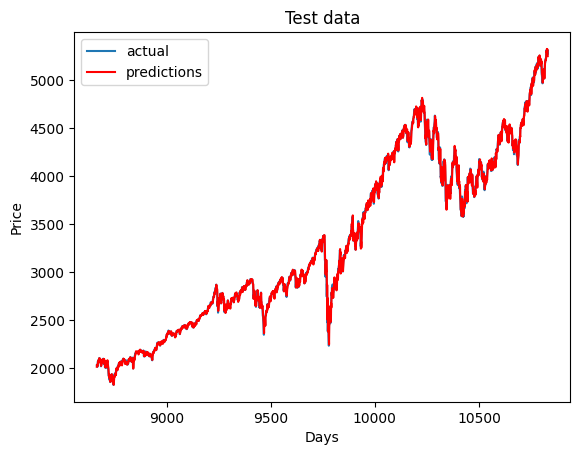

Correctly Classified: 1846/2166
Accuracy: 85.22622345337027%, error_margin of $50
Correctly Classified: 2108/2166
Accuracy: 97.32225300092337%, error_margin of $100


In [129]:
print(train_index.shape, test_index.shape)
plt.plot(test_index, y_test, label="actual")
plt.plot(test_index, y_pred, color="red", label="predictions")
plt.title("Test data")
plt.ylabel("Price")
plt.xlabel("Days")
plt.legend()
plt.show()


error_margin = 50
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

error_margin = 100
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")



In [118]:
print(f"Tomorrows Price: {y_pred[-1]}")
print(y_pred[-15:])
print(y_test[-15:])

Tomorrows Price: 5250.0
[5121. 5172. 5197. 5205. 5212. 5207. 5227. 5278. 5302. 5290. 5325. 5302.
 5322. 5300. 5250.]
[5180. 5187. 5187. 5214. 5222. 5221. 5246. 5308. 5297. 5303. 5308. 5321.
 5307. 5267. 5304.]


# Autoregressive

We previously restricted the last 100 days from our data and we use it to test our auto regressive model that feeds the prediction back into the data. 

[5127.79003906 5180.74023438 5187.70019531 5187.66992188 5214.08007812
 5222.68017578 5221.41992188 5246.68017578 5308.14990234 5297.10009766
 5303.27001953 5308.12988281 5321.41015625 5307.00976562 5267.83984375] (10829, 365)


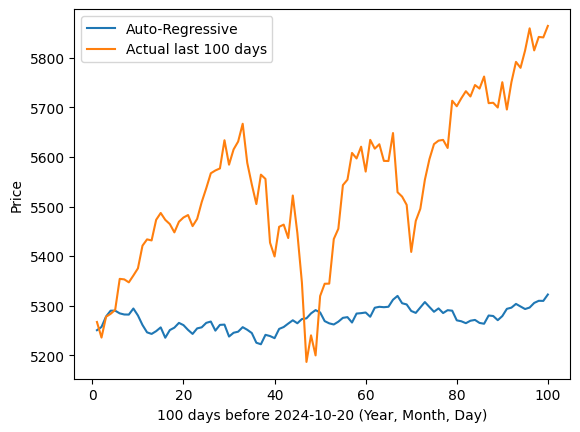

First few days


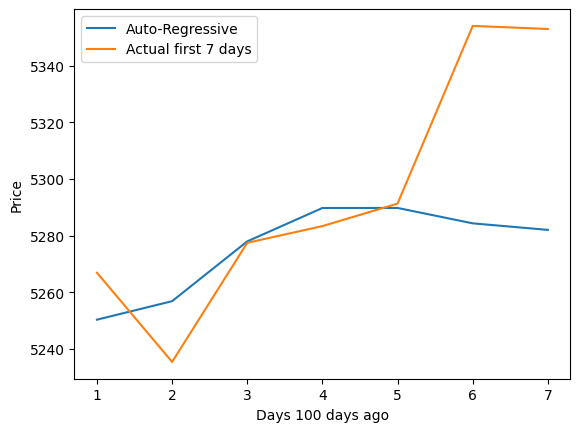

In [142]:
# take the last bin and perform a prediction
print(bins[-1][-15:], bins.shape)

running_bin = bins[-1].copy()

next_predictions = []
for i in range(100): # predict the next 100 days
    prediction = model.predict([running_bin])

    # feed the prediction back into the input
    running_bin[:-1] = running_bin[1:]
    running_bin[-1] = prediction[0]

    # store predictions
    next_predictions.append(prediction[0])

# print(next_predictions[-10:])
days = np.arange(1, len(next_predictions) + 1)

# plot the predictions
plt.figure()
plt.plot(days, next_predictions, label = "Auto-Regressive")
plt.plot(days, restricted_df, label = "Actual last 100 days")
plt.xlabel("100 days before " + end + " (Year, Month, Day)")
plt.ylabel("Price")
plt.legend()
plt.show()

print("First few days")
# plot the predictions
plt.figure()
plt.plot(days[:7], next_predictions[:7], label = "Auto-Regressive")
plt.plot(days[:7], restricted_df[:7], label = "Actual first 7 days")
plt.xlabel("Days 100 days ago")
plt.ylabel("Price")
plt.legend()
plt.show()


# Conclusion

The linear model is able to predict well for the first few days (The first 5 days, based on the plot). Once the predictions become separated from the actual price, the predictions go in totally different directions.

- This is not particularly bad, as we can continue to feed in the actual data and predict the next 5 days